# Creating synthetic data defined from Gaussian distribution

### Things to look into : 
1. Implementing Laplace Method
2. Model uncertainties in BNN and BSSNN (run through predictions multiple times)
3. Attempting different values of \rho for BSSNN and looking at performance / KL divergence evolution

In [1]:
# PyTorch Imports
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Normal

# Basic Python Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import sys  


from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Module Imports
from Modules.BayesLinear import BayesLinear, BLSS
from Modules.Loss import BKLLoss


import random
from sklearn.preprocessing import StandardScaler

random.seed(10)

/var/folders/j0/m3t4l9gx39l1t4djrcsyb3h80000gn/T/ipykernel_1409/3911799745.py:41: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig) #, auto_add_to_figure=False)


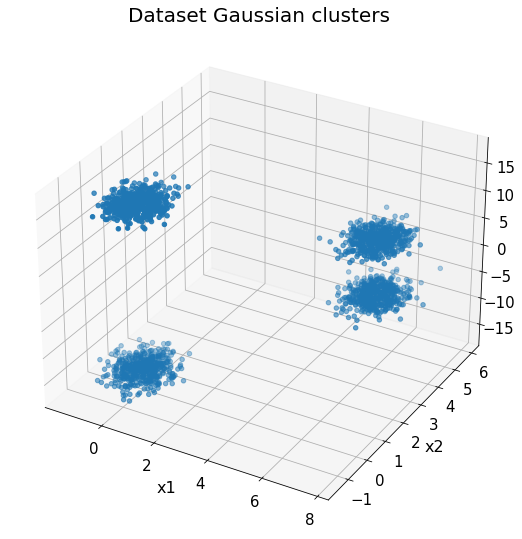

In [2]:
#center_locations = [[8, 8], [8, 4], [2, 8], [2, 4]]
center_locations = [[0, 0], [4, 6]]
X, y_true = make_blobs(n_samples=2000, centers=center_locations,
                       cluster_std=0.50, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

# Plot the data with K Means Labels
kmeans = KMeans(2, random_state=0)
labels = kmeans.fit(X).predict(X)

# Create gaussian distributed labels
mu = [-5, 5, -15, 15]
sigma = [0.5, 0.5, 0.5, 0.5]

labels = labels.astype(float)
labels0 = np.where(labels==0)[0]
labels1 = np.where(labels==1)[0]

assert len(labels0) == len(labels1), 'Error : Clusters do not have the same number of samples'
n = len(labels0)

size1 = labels0[0:int(n/2)]
size2 = labels0[int(n/2):n]
size3 = labels1[0:int(n/2)]
size4 = labels1[int(n/2):n]

s1 = np.random.normal(loc=mu[0], scale=sigma[0], size=len(size1))
s2 = np.random.normal(mu[1], sigma[1], len(size2))
s3 = np.random.normal(mu[2], sigma[2], len(size3))
s4 = np.random.normal(mu[3], sigma[3], len(size4))

#replace categorical labels with distribution
labels[size1] = s1
labels[size2] = s2
labels[size3] = s3
labels[size4] = s4

# plot 3D scatter data.
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14,7))
ax = Axes3D(fig) #, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(X[:, 0], X[:, 1], labels)
plt.grid()
plt.title('Dataset Gaussian clusters', fontsize=20)
plt.xlabel('x1', fontsize=16)
plt.ylabel('x2', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.zaxis.set_tick_params(labelsize=15)
plt.show()

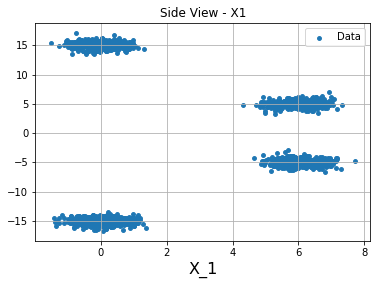

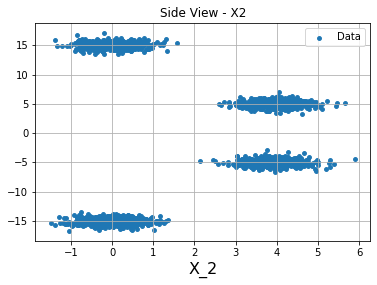

In [3]:
plt.figure()
plt.scatter(X[:, 0], labels, s=15, label='Data')
plt.title('Side View - X1')
plt.xlabel('X_1', fontsize=16)
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(X[:, 1], labels, s=15, label='Data')
plt.title('Side View - X2')
plt.xlabel('X_2', fontsize=16)
plt.grid()
plt.legend()
plt.show()

In [4]:
xx = X.copy()
x = torch.from_numpy(xx)
y = torch.from_numpy(labels)

x = x.float()
y = y.float()

## Feed-Forward Neural Network
Skal FFNN kun have en feature i output (middelværdi), eller skal vi også bestemmelse normalfordeling for data usikkerheder med denne model, for at sammenligne med BNN (ergo have 2 output features)?

In [5]:
class DenseLinear(Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(DenseLinear, self).__init__()
        self.hidden1 = nn.Linear(in_features=n_feature, out_features=n_hidden, bias=True)
        self.hidden2 = nn.Linear(in_features=n_hidden, out_features=n_hidden, bias=True)
        self.predict = nn.Linear(in_features=n_hidden, out_features=n_output, bias=True)
        
    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.predict(x)

        return x
    
FFNN = DenseLinear(n_feature=2, n_hidden=100, n_output=1)
print(FFNN)

DenseLinear(
  (hidden1): Linear(in_features=2, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
)


### Training

In [6]:
n_epochs = 1000 # or whatever
batch_size = 64 # or whatever

FFNN = FFNN.float()
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()

mse_epoch = []
mae_epoch = []
optimizer = optim.Adam(FFNN.parameters(),  lr=0.001)

for epoch in range(n_epochs):

    # Randomly permute indexes
    permutation = torch.randperm(x.size()[0])

    # Run batch
    count = 0
    mse_all = 0
    mae_all = 0
    
    for i in range(0, x.size()[0], batch_size):
        count +=1
        optimizer.zero_grad()
        
        indices = permutation[i:i+batch_size]
        
        batch_x, batch_y = x[indices], y[indices]
        
        prediction = FFNN(batch_x)
        
        loss = mse_loss(prediction.squeeze(), batch_y.float())
        mse_all += mse_loss(prediction.squeeze(), batch_y.float())
        mae_all += mae_loss(prediction.squeeze(), batch_y.float())
        
        loss.backward()
        
        optimizer.step()
   
    mse_epoch.append(mse_all/count)
    mae_epoch.append(mae_all/count)
    # print(mse_epoch)
        
    if epoch % 100 == 0:
        print('Epoch', epoch, '    Loss', loss.item())

Epoch 0     Loss 91.07159423828125
Epoch 100     Loss 110.7799301147461
Epoch 200     Loss 158.7984161376953
Epoch 300     Loss 147.36050415039062
Epoch 400     Loss 118.90064239501953
Epoch 500     Loss 91.38832092285156
Epoch 600     Loss 141.23924255371094
Epoch 700     Loss 118.910888671875
Epoch 800     Loss 132.1751251220703
Epoch 900     Loss 138.80313110351562


In [7]:
print('MSE Loss :', min(mse_epoch))
print('MAE Loss :', min(mae_epoch))

MSE Loss : tensor(111.1572, grad_fn=<DivBackward0>)
MAE Loss : tensor(9.1507, grad_fn=<DivBackward0>)


### Predictions

/var/folders/j0/m3t4l9gx39l1t4djrcsyb3h80000gn/T/ipykernel_1409/1595125204.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig) #, auto_add_to_figure=False)


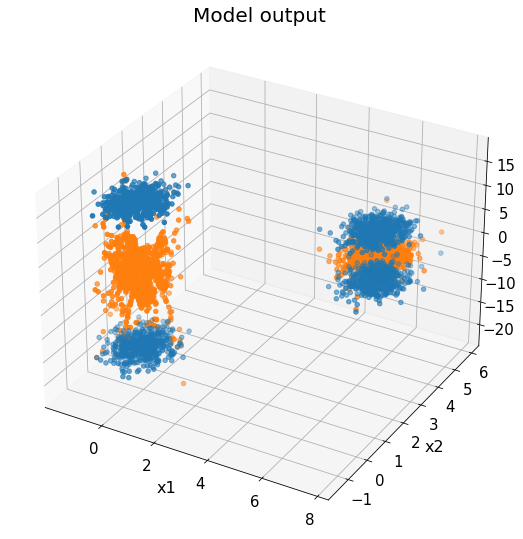

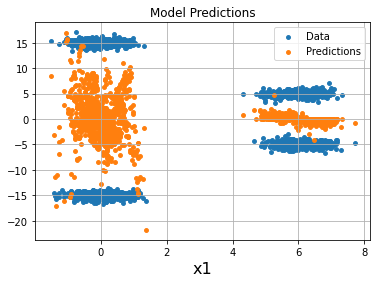

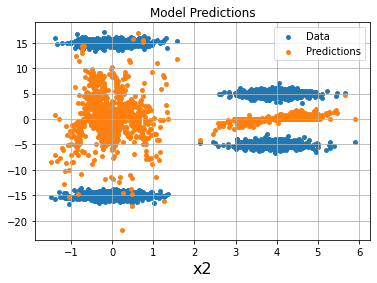

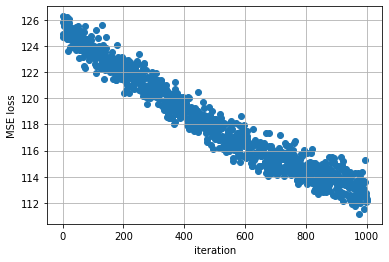

In [8]:
prediction = FFNN(x.float()).detach().numpy()

fig = plt.figure(figsize=(14,7))
ax = Axes3D(fig) #, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(X[:, 0], X[:, 1], labels, label='Data')
ax.scatter(X[:, 0], X[:, 1], prediction, label='Predictions')
plt.grid()
plt.title('Model output', fontsize=20)
plt.xlabel('x1', fontsize=16)
plt.ylabel('x2', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.zaxis.set_tick_params(labelsize=15)
plt.show()


plt.figure()
plt.scatter(X[:, 0], y, s=15, label='Data')
plt.scatter(X[:, 0], prediction, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x1', fontsize=16)
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(X[:, 1], y, s=15, label='Data')
plt.scatter(X[:, 1], prediction, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x2', fontsize=16)
plt.grid()
plt.legend()
plt.show()

mse_losses = [mse.detach().numpy() for mse in mse_epoch]
iterations = np.linspace(0, len(mse_losses), len(mse_losses))
plt.figure()
plt.scatter(iterations, mse_losses)
plt.ylabel('MSE loss')
plt.xlabel('iteration')
plt.grid()
plt.show()


## Bayes Linear Neural Network

In [9]:
class BayesLinearNN(Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(BayesLinearNN, self).__init__()
        self.hidden1 = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_feature, out_features=n_hidden, bias=True)   # hidden layer
        self.hidden2 = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_hidden, bias=True)
        self.predict = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_output, bias=True)   # output layer
        
    def forward(self, x):
        x = torch.tanh(self.hidden1(x))
        x = torch.tanh(self.hidden2(x))
        x = self.predict(x)
        
        #mu, log_std = x.chunk(2, dim=1)
        
        #dist = Normal(mu, torch.exp(log_std))

        return x
    
BNN = BayesLinearNN(n_feature=2, n_hidden=100, n_output=1)
print(BNN)

BayesLinearNN(
  (hidden1): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=100, bias=True)
  (hidden2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=100, bias=True)
  (predict): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=1, bias=True)
)


### Training

In [10]:
n_epochs = 5000 # or whatever
batch_size = 64 # or whatever

BNN = BNN.float()

kl_loss = BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(BNN.parameters(),  lr=0.001)
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()

mse_epoch = []
mae_epoch = []
kl_epoch = []
ELBO_epoch = []

for epoch in range(n_epochs):

    # Randomly permute indexes
    permutation = torch.randperm(x.size()[0])

    # Run batch
    count = 0
    mse_all = 0
    mae_all = 0
    kl_all = 0
    ELBO_all = 0
    
    for i in range(0, x.size()[0], batch_size):
        count += 1
        optimizer.zero_grad()
        
        indices = permutation[i:i+batch_size]
        
        batch_x, batch_y = x[indices], y[indices]
        
        #distribution = BNN(batch_x)
        prediction = BNN(batch_x)
        
        kl = kl_loss(BNN)
        
        #loss = -distribution.log_prob(batch_y.float()).sum(1).mean() + kl_weight*kl
        loss = mse_loss(prediction.squeeze(), batch_y.float()) + kl_weight*kl      
        
        mse_all += mse_loss(prediction.squeeze(), batch_y.float())
        mae_all += mae_loss(prediction.squeeze(), batch_y.float())
        kl_all += kl
        ELBO_all += loss
        
        loss.backward()
        
        optimizer.step()
    
    mse_epoch.append(mse_all/count)  
    mae_epoch.append(mae_all/count)
    kl_epoch.append(kl_all/count)
    ELBO_epoch.append(ELBO_all/count)
    
    if epoch % 500 == 0:
        print('Epoch', epoch, '    Loss', loss.item())

Epoch 0     Loss 149.86660766601562
Epoch 500     Loss 92.17768096923828
Epoch 1000     Loss 115.03578186035156
Epoch 1500     Loss 132.48605346679688
Epoch 2000     Loss 102.0569076538086
Epoch 2500     Loss 100.21916961669922
Epoch 3000     Loss 49.450218200683594
Epoch 3500     Loss 102.56120300292969
Epoch 4000     Loss 80.52362060546875
Epoch 4500     Loss 69.11646270751953


### Predictions

/var/folders/j0/m3t4l9gx39l1t4djrcsyb3h80000gn/T/ipykernel_1409/1539862087.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig) #, auto_add_to_figure=False)


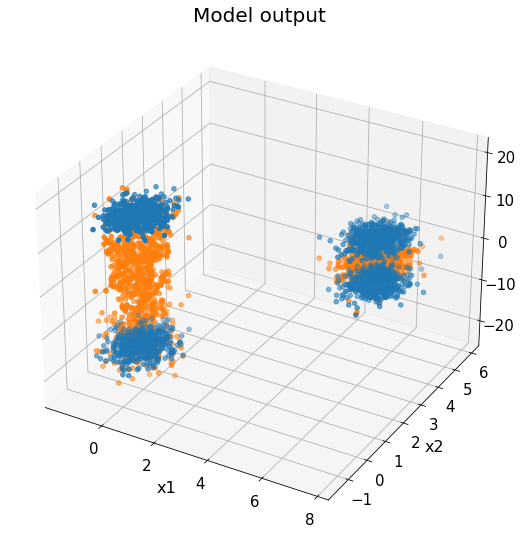

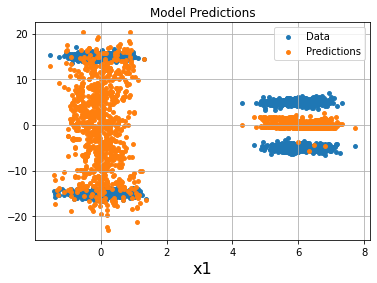

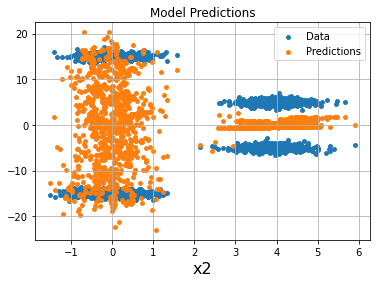

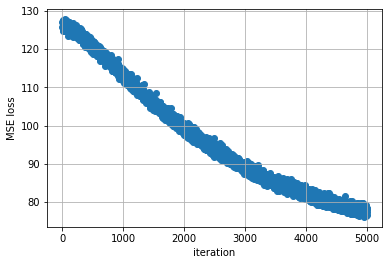

In [11]:
prediction = BNN(x.float()).detach().numpy()

fig = plt.figure(figsize=(14,7))
ax = Axes3D(fig) #, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(X[:, 0], X[:, 1], labels, label='Data')
ax.scatter(X[:, 0], X[:, 1], prediction, label='Predictions')
plt.grid()
plt.title('Model output', fontsize=20)
plt.xlabel('x1', fontsize=16)
plt.ylabel('x2', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.zaxis.set_tick_params(labelsize=15)
plt.show()

plt.figure()
plt.scatter(X[:, 0], y, s=15, label='Data')
plt.scatter(X[:, 0], prediction, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x1', fontsize=16)
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(X[:, 1], y, s=15, label='Data')
plt.scatter(X[:, 1], prediction, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x2', fontsize=16)
plt.grid()
plt.legend()
plt.show()

mse_losses = [mse.detach().numpy() for mse in mse_epoch]
iterations = np.linspace(0, len(mse_losses), len(mse_losses))
plt.figure()
plt.scatter(iterations, mse_losses)
plt.ylabel('MSE loss')
plt.xlabel('iteration')
plt.grid()
plt.show()

## Spectral Smoothing
Only done for gradient computations during training.
We must reparametrise the inputs to the Gaussian distributions (\mu and \sigma) by applying an opertator from the OU semigroup. This created a correlated variable. 

In [12]:
class BayesLinearSpectralSmoothing(Module):
    def __init__(self, rho, n_feature, n_hidden, n_output):
        super(BayesLinearSpectralSmoothing, self).__init__()
        self.hidden1 = BLSS(rho=rho, prior_mu=0, prior_sigma=0.1, in_features=n_feature, out_features=n_hidden, bias=True)   # hidden layer
        self.hidden2 = BLSS(rho=rho, prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_hidden, bias=True)
        self.predict = BLSS(rho=rho, prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_output, bias=True)   # output layer
        
    def forward(self, x):
        x = torch.tanh(self.hidden1(x))
        x = torch.tanh(self.hidden2(x))
        x = self.predict(x)

        return x
    
BSSNN = BayesLinearSpectralSmoothing(rho=0.1, n_feature=2, n_hidden=100, n_output=1)
print(BSSNN)

BayesLinearSpectralSmoothing(
  (hidden1): BLSS(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=100, bias=True)
  (hidden2): BLSS(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=100, bias=True)
  (predict): BLSS(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=1, bias=True)
)


In [13]:
n_epochs = 5000 # or whatever
batch_size = 64 # or whatever

BSSNN = BSSNN.float()

kl_loss = BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(BSSNN.parameters(),  lr=0.001)
mse_loss = nn.MSELoss()
mse_all = []

for epoch in range(n_epochs):

    # Randomly permute indexes
    permutation = torch.randperm(x.size()[0])

    # Run batch
    count = 0
    mse_all = 0
    for i in range(0, x.size()[0], batch_size):
        count += 1
        optimizer.zero_grad()
        
        indices = permutation[i:i+batch_size]
        
        batch_x, batch_y = x[indices], y[indices]
        
        #distribution = BNN(batch_x)
        prediction = BSSNN(batch_x)
        
        kl = kl_loss(BSSNN)
        
        #loss = -distribution.log_prob(batch_y.float()).sum(1).mean() + kl_weight*kl
        loss = mse_loss(prediction.squeeze(), batch_y.float()) + kl_weight*kl

        mse_all += mse_loss(prediction.squeeze(), batch_y.float())
        
        loss.backward()
        
        optimizer.step()
    
    mse_epoch.append(mse_all/count)  
        
    if epoch % 500 == 0:
        print('Epoch', epoch, '    Loss', loss.item())

Epoch 0     Loss 120.71150207519531
Epoch 500     Loss 140.8795623779297
Epoch 1000     Loss 106.62437438964844
Epoch 1500     Loss 123.90538024902344
Epoch 2000     Loss 62.13917922973633
Epoch 2500     Loss 153.34738159179688
Epoch 3000     Loss 48.02968978881836
Epoch 3500     Loss 75.00491333007812
Epoch 4000     Loss 86.18909454345703
Epoch 4500     Loss 132.78359985351562


/var/folders/j0/m3t4l9gx39l1t4djrcsyb3h80000gn/T/ipykernel_1409/2874943887.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig) #, auto_add_to_figure=False)


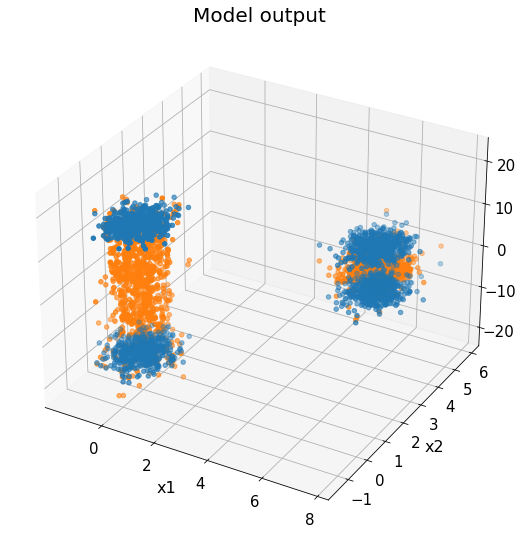

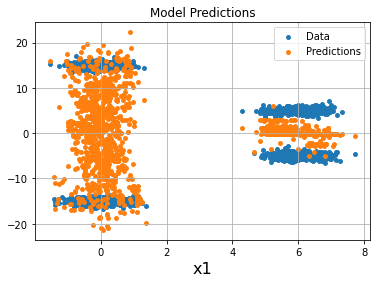

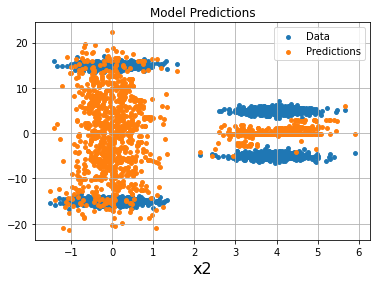

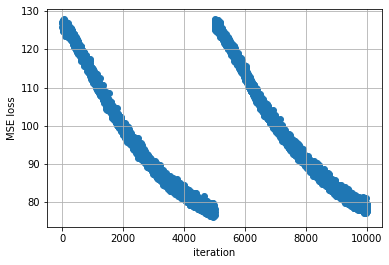

In [14]:
prediction_01 = BSSNN(x.float()).detach().numpy()
# prediction_09 = BSSNN(x.float()).detach().numpy()

fig = plt.figure(figsize=(14,7))
ax = Axes3D(fig) #, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(X[:, 0], X[:, 1], labels, label='Data')
ax.scatter(X[:, 0], X[:, 1], prediction_01, label='Predictions')
plt.grid()
plt.title('Model output', fontsize=20)
plt.xlabel('x1', fontsize=16)
plt.ylabel('x2', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.zaxis.set_tick_params(labelsize=15)
plt.show()

plt.figure()
plt.scatter(X[:, 0], y, s=15, label='Data')
plt.scatter(X[:, 0], prediction_01, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x1', fontsize=16)
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(X[:, 1], y, s=15, label='Data')
plt.scatter(X[:, 1], prediction_01, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x2', fontsize=16)
plt.grid()
plt.legend()
plt.show()

mse_losses = [mse.detach().numpy() for mse in mse_epoch]
iterations = np.linspace(0, len(mse_losses), len(mse_losses))
plt.figure()
plt.scatter(iterations, mse_losses)
plt.ylabel('MSE loss')
plt.xlabel('iteration')
plt.grid()
plt.show()

## Laplace Transform

In [15]:
from laplace import Laplace

n_epochs = 50000 # or whatever
batch_size = 64 # or whatever

from torch.utils.data import DataLoader, TensorDataset
batch_size = 64
train_loader = DataLoader(TensorDataset(x, y), batch_size=batch_size)
model = FFNN
n_feature = 2
n_hidden = 100
n_output = 1
model = torch.nn.Sequential(nn.Linear(in_features=n_feature, out_features=n_hidden, bias=True),
                            torch.nn.ReLU(),
                            nn.Linear(in_features=n_hidden, out_features=n_hidden, bias=True),
                            torch.nn.ReLU(),
                            nn.Linear(in_features=n_hidden, out_features=n_output, bias=True))

mse_loss = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(),  lr=0.001)
for i in range(n_epochs):
    # Run batch
    for x_train, y_train in train_loader:
        optimizer.zero_grad()
        prediction = model(x_train.float())     # input x and predict based on x
        mse = mse_loss(prediction.squeeze(), y_train.squeeze().float())
        mse.backward()
        optimizer.step()

# User-specified LA flavor
la = Laplace(model, 'regression',
             subset_of_weights='all',
             hessian_structure='diag')

la.fit(train_loader)

log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)

hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)

for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

/Users/oliverdurfeldtpedros/Documents/PythonEnv/DeepLearning/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/oliverdurfeldtpedros/Documents/PythonEnv/DeepLearning/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [16]:
f_mu, f_var = la(x)
mse = mse_loss(f_mu, y_train.squeeze().float())

f_mu = f_mu.squeeze().detach().numpy()
f_sigma = f_var.squeeze().sqrt().numpy()

pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

print(f_mu.size)
print(X[:, 0].size)

2000
2000


/Users/oliverdurfeldtpedros/Documents/PythonEnv/DeepLearning/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([2000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/var/folders/j0/m3t4l9gx39l1t4djrcsyb3h80000gn/T/ipykernel_1409/1444693344.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig) #, auto_add_to_figure=False)


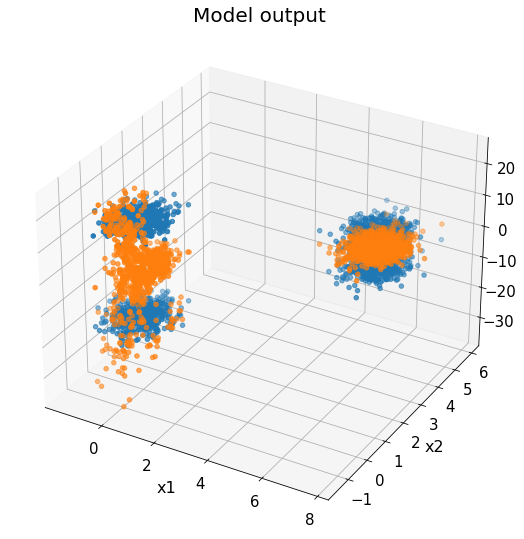

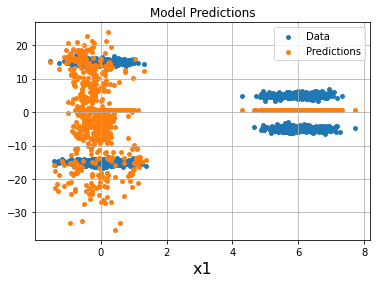

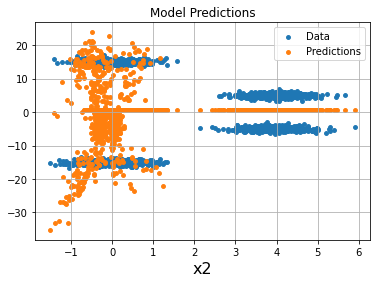

In [17]:
fig = plt.figure(figsize=(14,7))
ax = Axes3D(fig) #, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(X[:, 0], X[:, 1], labels, label='Data')
ax.scatter(X[:, 0], X[:, 1], f_mu, label='Predictions')
plt.grid()
plt.title('Model output', fontsize=20)
plt.xlabel('x1', fontsize=16)
plt.ylabel('x2', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.zaxis.set_tick_params(labelsize=15)
plt.show()

plt.subplots(2)
plt.figure()
plt.scatter(X[:, 0], y, s=15, label='Data')
plt.scatter(X[:, 0], f_mu, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x1', fontsize=16)
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(X[:, 1], y, s=15, label='Data')
plt.scatter(X[:, 1], f_mu, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x2', fontsize=16)
plt.grid()
plt.legend()
plt.show()

/var/folders/j0/m3t4l9gx39l1t4djrcsyb3h80000gn/T/ipykernel_1409/2421922053.py:41: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig) #, auto_add_to_figure=False)


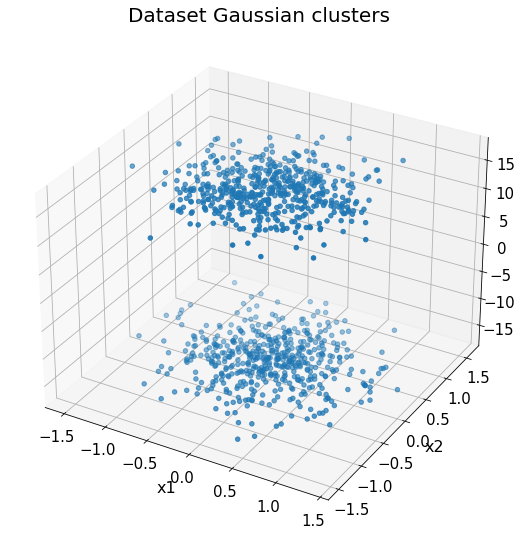

In [18]:
#center_locations = [[8, 8], [8, 4], [2, 8], [2, 4]]
center_locations = [[0, 0], [4, 6]]
X, y_true = make_blobs(n_samples=2000, centers=center_locations,
                       cluster_std=0.50, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

# Plot the data with K Means Labels
kmeans = KMeans(2, random_state=0)
labels = kmeans.fit(X).predict(X)

# Create gaussian distributed labels
mu = [-5, 5, -15, 15]
sigma = [0.5, 0.5, 0.5, 0.5]

labels = labels.astype(float)
labels0 = np.where(labels==0)[0]
labels1 = np.where(labels==1)[0]

assert len(labels0) == len(labels1), 'Error : Clusters do not have the same number of samples'
n = len(labels0)

size1 = labels0[0:int(n/2)]
size2 = labels0[int(n/2):n]
size3 = labels1[0:int(n/2)]
size4 = labels1[int(n/2):n]

s1 = np.random.normal(loc=mu[0], scale=sigma[0], size=len(size1))
s2 = np.random.normal(mu[1], sigma[1], len(size2))
s3 = np.random.normal(mu[2], sigma[2], len(size3))
s4 = np.random.normal(mu[3], sigma[3], len(size4))

#replace categorical labels with distribution
labels[size1] = s1
labels[size2] = s2
labels[size3] = s3
labels[size4] = s4

# plot 3D scatter data.
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14,7))
ax = Axes3D(fig) #, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(X[labels1, 0], X[labels1, 1], labels[labels1])
plt.grid()
plt.title('Dataset Gaussian clusters', fontsize=20)
plt.xlabel('x1', fontsize=16)
plt.ylabel('x2', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.zaxis.set_tick_params(labelsize=15)
plt.show()

/Users/oliverdurfeldtpedros/Documents/PythonEnv/DeepLearning/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


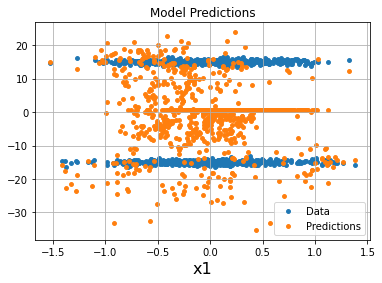

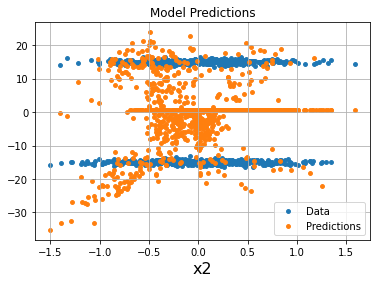

In [19]:
xx = X[labels1,:].copy()
x = torch.from_numpy(xx)
y = torch.from_numpy(labels[labels1])

x = x.float()
y = y.float()

f_mu, f_var = la(x)
mse = mse_loss(f_mu, y_train.squeeze().float())

f_mu = f_mu.squeeze().detach().numpy()

plt.figure()
plt.scatter(x[:, 0], y, s=15, label='Data')
plt.scatter(x[:, 0], f_mu, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x1', fontsize=16)
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(x[:, 1], y, s=15, label='Data')
plt.scatter(x[:, 1], f_mu, s=15, label='Predictions')
plt.title('Model Predictions')
plt.xlabel('x2', fontsize=16)
plt.grid()
plt.legend()
plt.show()